# ANALIZAMOS LA INFORMACIÓN DEL AYUNTAMIENTO DE MADRID PARA OBTENER UNA PREDICCIÓN DE LA CARGA DE TRÁFICO EN LA M30


CARGAMOS LAS LIBRERIAS DE PYTHON

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

CARGAMOS LAS SERIES TEMPORALES Y SELECCIONAMOS EL PUNTO CON MAS CARGA DE LA M30

In [2]:
from os import walk

M30_PUNTO = 'PM10981'
scanned = 0

for (path, ficheros, archivos) in walk("F:/201711_dataton_opendata_madrid/dat/datos_trafico"):
    for file in archivos:
        scanned = scanned + 1
        spath = path + "/" + file
        print(spath)
        tmp_df = pd.read_csv(spath)
        tmp_df = tmp_df[tmp_df.tipo_elem == 'PUNTOS MEDIDA M-30']        
        tmp_df = tmp_df[tmp_df.identif== M30_PUNTO]
        print (tmp_df['identif'].count())
        if scanned == 1:
            df = tmp_df
        else:
            df = df.append(tmp_df)
    print ('Ficheros tratatos: ', scanned)
    print ('Total registros: ', df['identif'].count())   


F:/201711_dataton_opendata_madrid/dat/datos_trafico/201601_DatosTrafico.csv
2014
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201602_DatosTrafico.csv
2784
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201603_DatosTrafico.csv
2725
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201604_DatosTrafico.csv
1873
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201605_DatosTrafico.csv
2752
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201606_DatosTrafico.csv
2711
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201607_DatosTrafico.csv
2976
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201608_DatosTrafico.csv
839
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201609_DatosTrafico.csv
2870
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201610_DatosTrafico.csv
2885
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201611_DatosTrafico.csv
2878
F:/201711_dataton_opendata_madrid/dat/datos_trafico/201612_DatosTrafico.csv
2976
F:/201711_dataton_opendata_ma

CARGAMOS LAS VACACIONES Y LES INCLUIMOS EL EFECTO SOBRE DIAS ANTERIORES Y POSTERIORES

In [3]:
hol = pd.read_csv('F:/201711_dataton_opendata_madrid/dat/calendario_2013_2018.csv',
                  encoding='utf-8',
                  sep= ';')
columnas = ['Dia', 'Festividad']
hol=hol[columnas]
hol.rename(columns={'Dia': 'ds', 'Festividad': 'holiday'}, inplace=True)
hol=hol[hol.holiday.notnull()]
hol['lower_window']=-1
hol['upper_window']=0
hol[0:5]



,ds,holiday,lower_window,upper_window
0,01/01/2013,AnioNuevo,-1,0
6,07/01/2013,Epifania del Senior,-1,0
76,18/03/2013,San Jose,-1,0
86,28/03/2013,Jueves Santo,-1,0
87,29/03/2013,Viernes Santo,-1,0


PREPARAMOS LA TABLA CON LAS COLUMNAS A ANALIZAR EN LA SERIE TEMPORAL


In [4]:
columnas = ['identif', 'fecha','carga']
tmp_df=df[columnas]
tmp_df=tmp_df.rename(columns={'fecha': 'ds', 'carga': 'y'})
tmp_df['cap'] = 100
#tmp_df['floor'] = 0
tmp_df[1:5]


,identif,ds,y,cap
748,PM10981,2016-01-01 09:15:00,13,100
859,PM10981,2016-01-09 10:00:00,51,100
1236,PM10981,2016-01-01 00:00:00,5,100
1568,PM10981,2016-01-09 07:30:00,24,100


EJECUTAMOS EL MODELO CON LAS CARACTERISTICAS:

    - growth = 'logistic'. Entendemos que el crecimiento no es líneal si no que tiene un punto de saturación
    - changepoint_prior_scale=0.5 Flexibilidad del modelo buscando puntos de cambio (incrementarlo flexibiliza el modelo)
    - changepoints = c('2014-01-01') Permite determinar puntos de cambio si se conocen.
    - interval_width=0.80 Controla el nivel de incertidumbre de los intervalos de confianza
    - seasonality_prior_scale: regularización de la estacionalidad (anual y semanal)(entre 0.01 y 10)
    - holidays_prior_scale: regularización de los festivos
    

In [5]:
model=Prophet(growth = 'logistic',
              yearly_seasonality=True,
              weekly_seasonality=True,
              daily_seasonality=True,
              changepoint_prior_scale=0.5,
              seasonality_prior_scale = 10,
              holidays=hol,
              holidays_prior_scale = 5,
              interval_width=0.90)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(tmp_df)

Obtenemos la predicción 

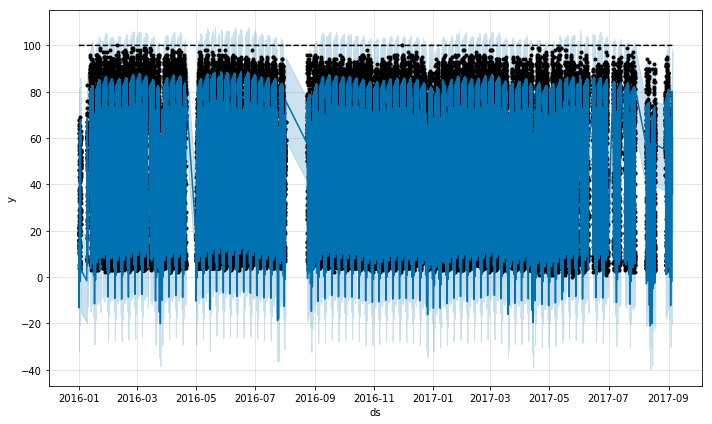

In [6]:
future = model.make_future_dataframe(periods=24*4, freq='H')
future['cap'] = 100
#future['floor'] = 0
forecast = model.predict(future)
model.plot(forecast)

DESAGREGAMOS LOS COMPONENTES


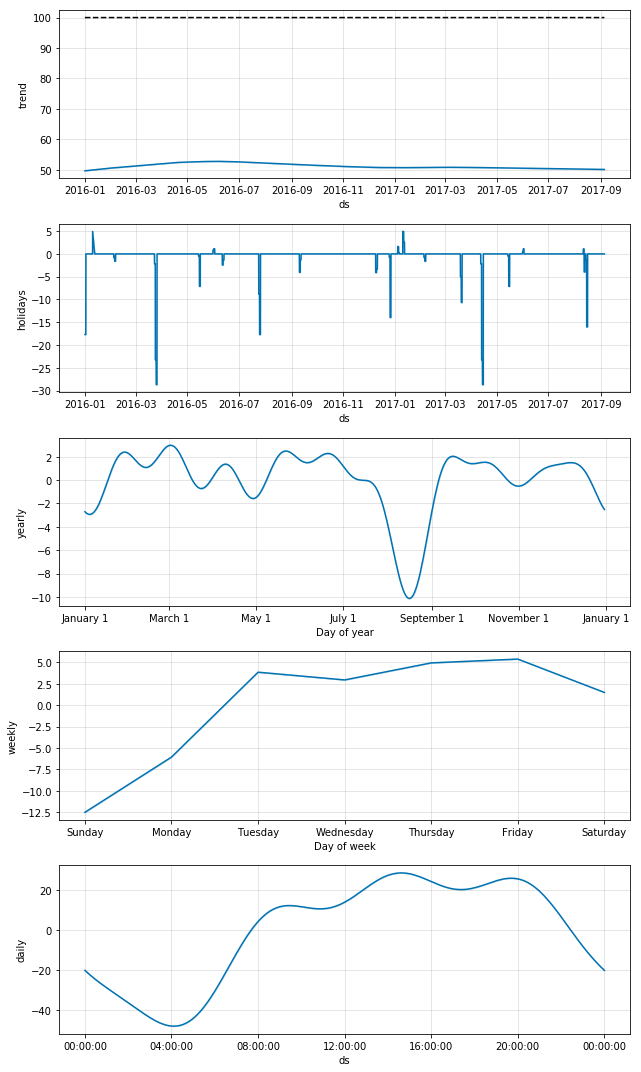

In [8]:
model.plot_components(forecast)

CROSSVALIDATION


In [9]:
RMSE_Yhat = ((tmp_df.y - forecast.yhat) ** 2).mean() ** .5
RMSE_Yhat_lower = ((tmp_df.y - forecast.yhat_lower) ** 2).mean() ** .5
RMSE_Yhat_upper = ((tmp_df.y - forecast.yhat_upper) ** 2).mean() ** .5
print('RMSE_Yhat:',RMSE_Yhat)
print('RMSE_Yhat_lower:',RMSE_Yhat_lower)
print('RMSE_Yhat_upper:',RMSE_Yhat_upper)

RMSE_Yhat: 38.26386553437454
RMSE_Yhat_lower: 42.12334485312762
RMSE_Yhat_upper: 42.43222192115899


In [87]:
columnas = ['ds','yhat', 'yhat_lower', 'yhat_upper']
forecast[columnas].tail()

,ds,yhat,yhat_lower,yhat_upper
2423,2017-07-04 01:00:00,10.793125,-8.888372,30.749902
2424,2017-07-04 02:00:00,0.301100,-18.477064,20.746076
2425,2017-07-04 03:00:00,-4.995729,-24.168001,15.766869
2426,2017-07-04 04:00:00,-2.774565,-23.092184,18.102176
2427,2017-07-04 05:00:00,6.084868,-13.642312,25.826362
